## Song Embeddings - Skipgram Recommender

In this notebook, we'll use human-made music playlists to learn song embeddings. We'll treat a playlist as if it's a sentence and the songs it contains as words. We feed that to the word2vec algorithm which then learns embeddings for every song we have. These embeddings can then be used to recommend similar songs. This technique is used by Spotify, AirBnB, Alibaba, and others. It accounts for a vast portion of their user activity, user media consumption, and/or sales (in the case of Alibaba).

The [dataset we'll use](https://www.cs.cornell.edu/~shuochen/lme/data_page.html) was collected by Shuo Chen from Cornell University. The dataset contains playlists from hundreds of radio stations from around the US.

## Importing packages and dataset

In [95]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE #scikit learn's TSNE
from urllib import request
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


The playlist dataset is a text file where every line represents a playlist. That playlist is basically a series of song IDs.

In [96]:
# Get the playlist dataset file
data = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/train.txt')

# Parse the playlist dataset file. Skip the first two lines as
# they only contain metadata
lines = data.read().decode("utf-8").split('\n')[2:]

# Remove playlists with only one song
playlists = [s.rstrip().split() for s in lines if len(s.split()) > 1]


The `playlists` variable now contains a python list. Each item in this list is a playlist containing song ids. We can look at the first two playlists here:

In [97]:
print( 'Playlist #1:\n ', playlists[0], '\n')
print( 'Playlist #2:\n ', playlists[1])

Playlist #1:
  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '2', '42', '43', '44', '45', '46', '47', '48', '20', '49', '8', '50', '51', '52', '53', '54', '55', '56', '57', '25', '58', '59', '60', '61', '62', '3', '63', '64', '65', '66', '46', '47', '67', '2', '48', '68', '69', '70', '57', '50', '71', '72', '53', '73', '25', '74', '59', '20', '46', '75', '76', '77', '59', '20', '43'] 

Playlist #2:
  ['78', '79', '80', '3', '62', '81', '14', '82', '48', '83', '84', '17', '85', '86', '87', '88', '74', '89', '90', '91', '4', '73', '62', '92', '17', '53', '59', '93', '94', '51', '50', '27', '95', '48', '96', '97', '98', '99', '100', '57', '101', '102', '25', '103', '3', '104', '105', '106', '107', '47', '108', '109', '110', '111', '112', '113', '25', '63', '62', '114', '115', '84', '116', '117',

In [98]:
#Cantidad de playlists
len(playlists)

11088

## Training the Word2Vec Model
Our dataset is now in the shape the the Word2Vec model expects as input. We pass the dataset to the model.

In [99]:
#window es el largo de palabras con el que se obtiene contexto
#vector size dimensionalidad de los word embeddings
model = Word2Vec(playlists, vector_size=32, window=20, negative=50, min_count=1, workers=4)

The model is now trained. Every song has an embedding. We only have song IDs, though, no titles or other info. Let's grab the song information file.

## Song Title and Artist File
Let's load and parse the file containing song titles and artists

In [100]:
songs_file = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/song_hash.txt')
songs_file = songs_file.read().decode("utf-8").split('\n')
songs = [s.rstrip().split('\t') for s in songs_file] #rstrip elimina espacios en blanco

In [101]:
songs_df = pd.DataFrame(data=songs, columns = ['id', 'title', 'artist'])
songs_df['id'].str.rstrip()
songs_df = songs_df.set_index('id')

In [102]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75263 entries, 0  to 
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   75262 non-null  object
 1   artist  75261 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [103]:
songs_df.head()

,title,artist
id,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross
2,Get Back Up (w\/ Chris Brown),T.I.
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher
4,Whip My Hair,Willow


In [104]:
#Como se puede observar los indices parece que tienen espacios en blanco al final
songs_df.index

Index(['0 ', '1 ', '2 ', '3 ', '4 ', '5 ', '6 ', '7 ', '8 ', '9 ',
       ...
       '75253 ', '75254 ', '75255 ', '75256 ', '75257 ', '75258 ', '75259 ',
       '75260 ', '75261 ', ''],
      dtype='object', name='id', length=75263)

In [105]:
#Buscar canciones por id
songs_df.iloc[[1,15,10000]]

,title,artist
id,,
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross
15,Hurt Me Soul,Lupe Fiasco
10000,Bring Me Down,Throwing Gravity


In [118]:
#Buscar artistas especificos
songs_df[songs_df['artist'].str.lower() == 'linkin park']

,title,artist
id,,
1407,Shadow Of The Day,Linkin Park
1808,Breaking The Habit,Linkin Park
1951,Runaway,Linkin Park
2007,Lying From You,Linkin Park
2079,Given Up,Linkin Park
2090,Numb,Linkin Park
2109,New Divide,Linkin Park
2119,Faint,Linkin Park
2147,In The End,Linkin Park


In [138]:
#Funcion para tener un output de canciones recomendadas basadas en su distancia - similitud de coseno
def recomendaciones(id):
    #print( songs_df.iloc[id] ) #Imprimir la cancion del id
    similar_songs = np.array(model.wv.most_similar(positive=str(id),topn=20))[:,0] #Buscar las canciones mas similares encontrando su id.
    return  songs_df.iloc[similar_songs]

In [139]:
#Observando canciones recomendadas para ña cancion de In the End de Linkin Park
recomendaciones(2147)

,title,artist
id,,
1808,Breaking The Habit,Linkin Park
1867,Daughter,Pearl Jam
1988,Soul To Squeeze,The Red Hot Chili Peppers
1966,Scar Tissue,The Red Hot Chili Peppers
2006,Basket Case,Green Day
3895,Are You Gonna Be My Girl,Jet
2076,(You Gotta) Fight For Your Right,The Beastie Boys
1823,H.,Tool
1818,Everlong,Foo Fighters


In [140]:
#Ejemplo de como se ven los titulos como una lista para poder iterar
recomendaciones(2147)['title'].values.tolist()

['Breaking The Habit',
 'Daughter',
 'Soul To Squeeze',
 'Scar Tissue',
 'Basket Case',
 'Are You Gonna Be My Girl',
 '(You Gotta) Fight For Your Right',
 'H.',
 'Everlong',
 "What It's Like",
 'Comedown',
 'Santeria',
 'Lightning Crashes',
 'Closer',
 'Lithium',
 'My Hero',
 'Savior',
 'Creep',
 "It's Been Awhile",
 'Epic']

In [141]:
#Index de las canciones recomendadas
recomendaciones(2147).index

Index(['1808 ', '1867 ', '1988 ', '1966 ', '2006 ', '3895 ', '2076 ', '1823 ',
       '1818 ', '1838 ', '1794 ', '2080 ', '2052 ', '1886 ', '1943 ', '2149 ',
       '1789 ', '2037 ', '1811 ', '2093 '],
      dtype='object', name='id')

### Exercise:

Build visualization for the embeddings of the song recommender.

t-SNE stands for t-distributed Stochastic Neighbouring Entities. Its a technique used for visualizing high dimensional data by reducing it to a 2 or 3 dimensions.

In [142]:
song_id = [2147, 71, 2, 36885]

In [143]:
keys = [] #Almacenar en esta lista las canciones a buscar

for id in song_id:
    keys.append(songs_df.iloc[id]['title'])#Se almacenan titulos de las canciones cercanas

In [144]:
keys

['In The End',
 'All I Do Is Win (w\\/ T-Pain, Ludacris, Rick Ross & Snoop Dogg)',
 'Get Back Up (w\\/ Chris Brown)',
 'Never Ends']

In [145]:
embedding_clusters = [] #Lista para contener los embeddings de las canciones recomendadas
song_clusters = [] #Lista para guardar titulos de canciones recomendadas

for id in song_id:
    embeddings = []
    ids = []
    for cancion_recomendada in recomendaciones(id).index: #Se itera por los indices de las canciones
        titulo = songs_df.loc[cancion_recomendada, 'title'] #Con base en el indice se busca el titulo de la canción y se guarda en esta variable.
        ids.append(titulo) #Se añade el titulo a la lista
        embeddings.append(model.wv[cancion_recomendada.strip()])
    embedding_clusters.append(embeddings)#Se almacena embeddings de las canciones
    song_clusters.append(ids)#Se almacenan titulos de las canciones cercanas

In [146]:
print("Embedding clusters:",embedding_clusters[0][0]) #Access vector of the first word only
print('song recommended',song_clusters[:2])

Embedding clusters: [-1.1642895  -2.162383    1.9673212   0.8897458   0.96770793  0.3651005
 -1.4275421   0.7780162  -0.9509524   2.1769273  -0.10466436  0.12813035
 -1.6234993  -1.5125321   0.15129317  0.29110146 -0.849327    1.525847
 -0.5598876   1.5881302   1.324263    0.8934215   0.93559945  0.22905356
 -1.4708831  -1.1018659  -1.4504997  -1.733116    1.2213539   0.3431258
  2.1037998   0.39265564]
song recommended [['Breaking The Habit', 'Daughter', 'Soul To Squeeze', 'Scar Tissue', 'Basket Case', 'Are You Gonna Be My Girl', '(You Gotta) Fight For Your Right', 'H.', 'Everlong', "What It's Like", 'Comedown', 'Santeria', 'Lightning Crashes', 'Closer', 'Lithium', 'My Hero', 'Savior', 'Creep', "It's Been Awhile", 'Epic'], ['Dancehall Hero', 'Skip To Ma Lue (w\\/ Ding Dong, Razz & Biggy)', 'Benz Punany', 'W.T.P.', 'Welcome Back', 'Puff It', 'Just You And I', 'Nah Sell Out', "I'm Ill (w\\/ Fabolous)", 'Clarks (w\\/ Popcaan & Gaza Slim)', 'De Neck Wine', '-', 'The Race', '-', 'Drinking 

In [147]:
embedding_clusters = np.array(embedding_clusters) #Convertir los clusters en un array
n, m, k = embedding_clusters.shape #geting the dimensions
tsne_model_en_2d = TSNE(perplexity=5, n_components=2, init='pca', n_iter=1500, random_state=2020)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2) #reshaping it into 2d so we can visualize it

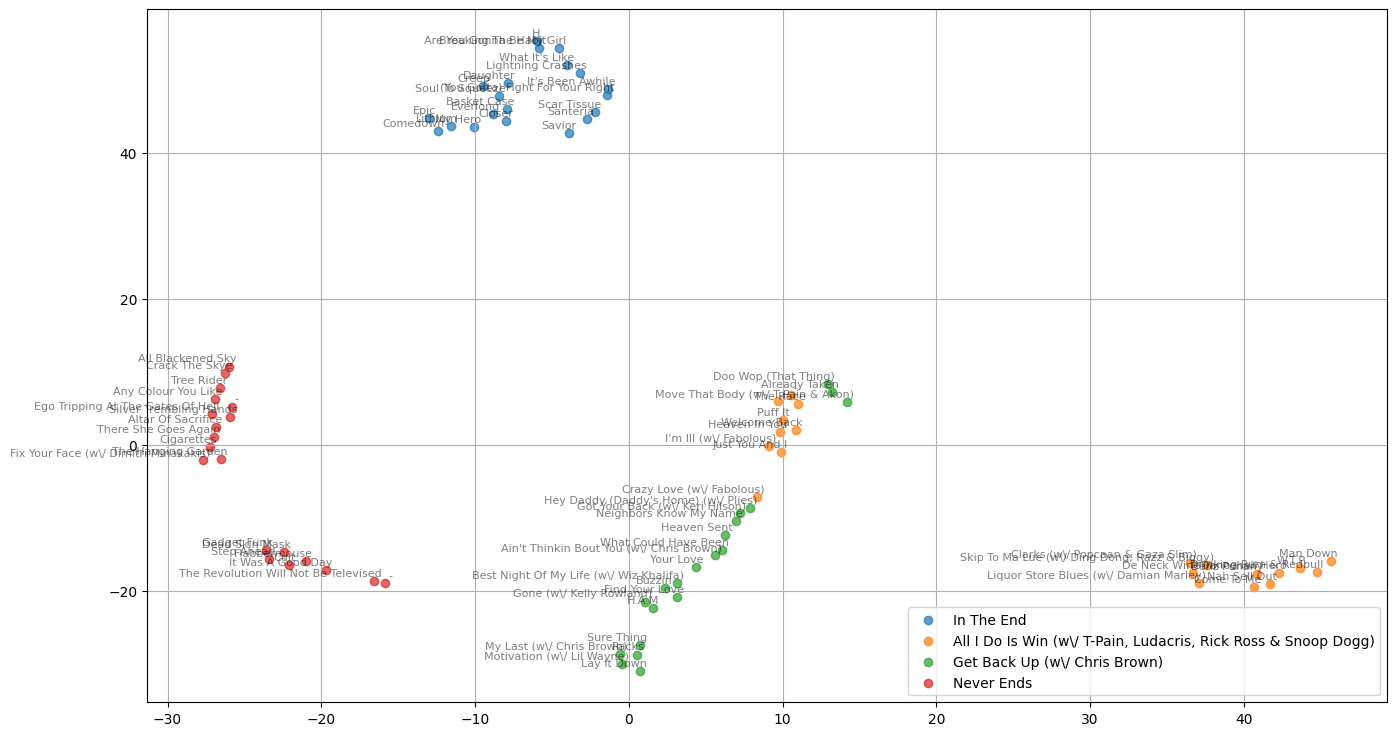

In [148]:
def tsne_plot_similar_words(labels, embedding_clusters, song_clusters, a=0.7):
    plt.figure(figsize=(16, 9))


    for label, embeddings, words in zip(labels, embedding_clusters, song_clusters):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot_similar_words(keys, embeddings_en_2d, song_clusters)

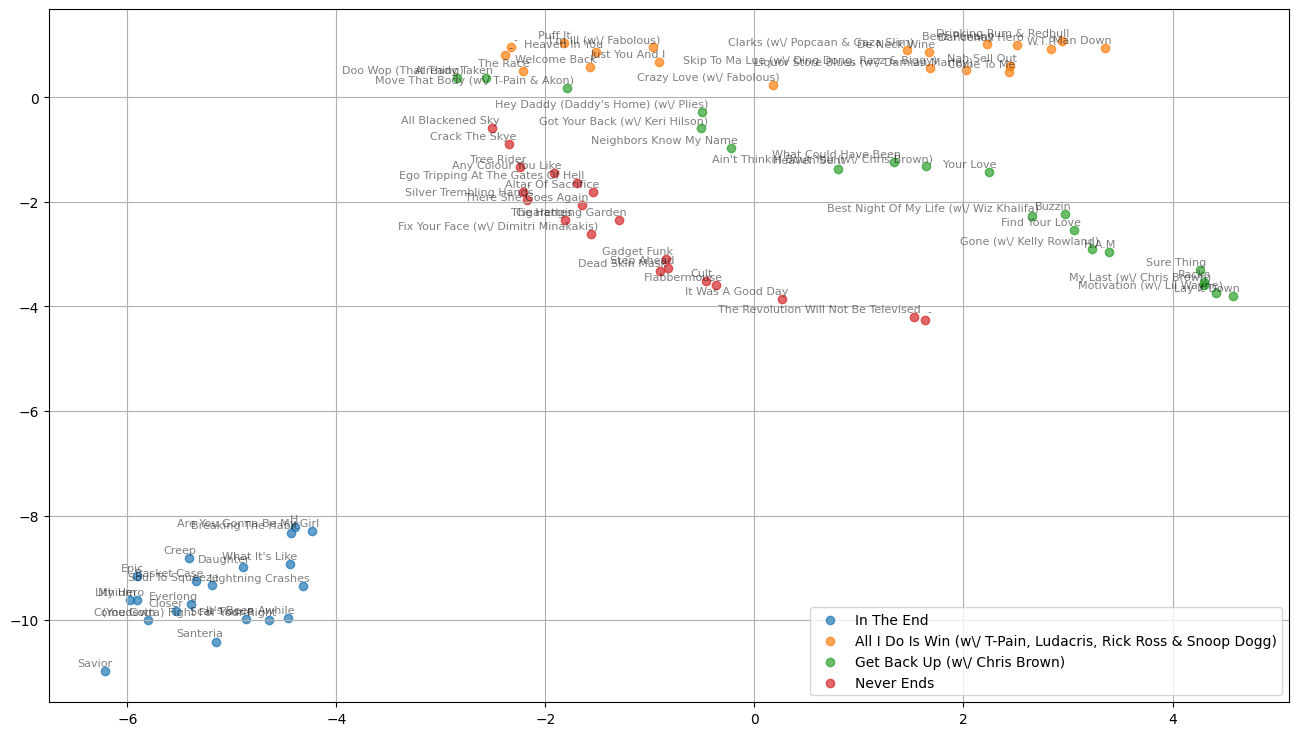

In [149]:
tsne_model_en_2d = TSNE(perplexity=25, n_components=2, init='pca', n_iter=1500, random_state=2020)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
tsne_plot_similar_words(keys, embeddings_en_2d, song_clusters)